# Project 5 Report
## Correspondence Grouping with Cuda
### Michael Davis, Luis Gonzalo, Pedro Peña

Description
======
This problem deals with pose estimation, i.e., $(\mathbf{p} \in \mathbf{R}^2, \mathbf{R} \in SO(2))$, of an object where the pose of the object is unknown. This problem is commonly dealt in computer vision where an arbitrary object in an image is detected but only 2D landmarks such as position in the image coordinates, e.g., pixel space, or higher level features are detected, but the position of the object in space relative to an arbitrary frame of reference is unknown. In this project, the input of the problem is an arbitrary set of 2D points in space in which we need to estimate the pose of these points. Moreover, we do not know the correspondence of these points relative to another dataset.  

Approach
======
Inspired by Iterative Closest Point (*ICP*) where the algorithm minimizes the difference between two point clouds, we implemented two optimization algorithms (numerical and analytical) to find the pose of the object. Therefore, we use a template point cloud that is a copy of the original dataset received and randomly perturb the pose. This is the initial input into the optimization. The optimization, therefore, receives two datasets, and uses the perturbed dataset to find the pose of the original dataset. But as stated in the description above, the correspondence between these two datasets are unknown, i.e., we do not know which points of the template corresponds to the points in the original dataset. In order to find the correspondence between points, we use a Nearest Neighbor algorithm that assumes that the points that are the closest to each other correspond to each other. Although it is a strong assumption, the iterative nature of the algorithm allows the points to settle down to an equilibrium where the final points attain the correct correspondence, or at least, it has very likelihood of doing so.

Numerical based Non-linear Least Squares
------
The iterative optimization utilizes Guass-Newton method, an algorithm to solve nonlinear least squares, to find the pose of the dataset. This approach numerically calculates the gradient of the system to find the fixed points of the function. The general function of the system is defined as: $ F(x) = x_{n+1} = x_n - \mathbf{J}^{-1}\cdot f(x)$, where $\mathbf{J}^{-1}$ is the pseudoinverse of the jacobian constructed from the gradients of the system. The gradients of the system are not explicitely known but they are determined by perturbing the system by some $\epsilon$. The system iterates until the change $dx = x_{n+1} - x_{n} = - \mathbf{J}^{-1}\cdot f(x) < \delta$.

Analytic based Least Squares
------
The analytic based approach utilizes the explicit gradient of the least squares to solve the regression. It is also iterative because it uses momemtum based control to stabilize the system.

Nearest Neighbor
------
The nearest neighbor used for this project is based on the Euclidean distance between points. Although it is a naive approach, it allowed us to parallelize the linear search between points where each thread was assigned an index on the template dataset and simultaneously found the point from the original dataset that has the minimum distance between the point in the template dataset. The parallelization was done with pycuda.

The kernel is written in CUDA.

```c
__global__ void nn(int *dest, double *a, double *b, int n) {
  const int idx = threadIdx.x + blockDim.x * blockIdx.x;
  // arrays are flattened when copied, so [[x, y], [x, y] ...] becomes [x, y, x, y, ...]
  const int i = 2 * idx;
  double min_value = 1.0 / 0.0;
  double dist;
  int min_index = 0;
  int j;

  for (j = 0; j < 2 * n; j += 2) {
    // hypotf is a builtin; returns the square root of the sum of the squared arguments
    dist = hypotf(b[j] - a[i], b[j + 1] - a[i + 1]);
    if (dist < min_value) {
      min_value = dist;
      min_index = j/2;
    }
  }

  dest[idx] = min_index;
}
```

    Each is assigned a point in the `a` cloud. Each thread then finds the nearest neighbor by checking each point in `b` using Euclidean distance. This parallelization requires $O(|a|)$ memory space and $O(|A|)


Implementation
======
Analytic based Least Squares
------

In [36]:
import match as m
import matplotlib
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
import ls_optimization_luis as lsopt


### Construct test point clouds

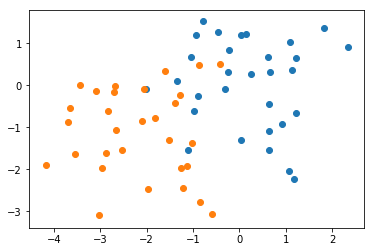

In [37]:
# reference pointcloud
X = np.random.normal(size=(30, 2))
# random rotation and shift
true_theta = np.random.uniform(low=-np.pi, high=np.pi)
true_b = np.random.normal(scale=4.0, size=(2,))
# transform reference pointcloud
Y = lsopt.transformPointCloud(X, -true_theta, -true_b)
Y += np.random.normal(scale=0.1, size=Y.shape)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1])
plt.show()

### Match point clouds

Converged after 287 iterations


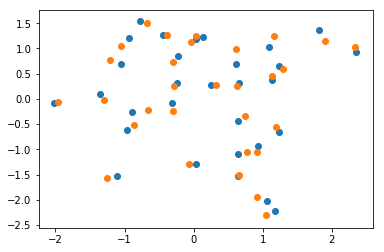

In [38]:

Y_match, cost = lsopt.matchPairs(X, Y, mu=0.05, max_iter=1000, tol=1e-10)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Y_match[:,0], Y_match[:,1])
plt.show()

Text(0.5,0,'iteration')

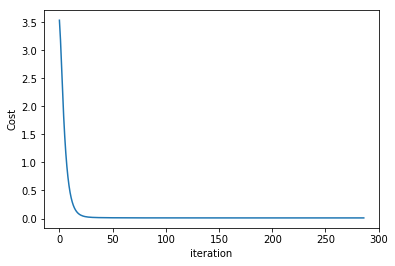

In [39]:
plt.plot(cost)
plt.ylabel('Cost')
plt.xlabel('iteration')

Numerical based Non-linear Least Squares
------

In [40]:
random_seed = random.randint(1, 262571)
random.seed(a=random_seed)
np.random.seed(seed=random_seed)

In [41]:
transformation = m.generate_transformation()

theta: 98


In [42]:
print("Transformation matrix:")
print(transformation)


Transformation matrix:
[[ -0.1391731   -0.99026807 -12.        ]
 [  0.99026807  -0.1391731   16.        ]
 [  0.           0.           1.        ]]


In [43]:
dataset = m.generate_dataset(transformation)

### Construct test point clouds

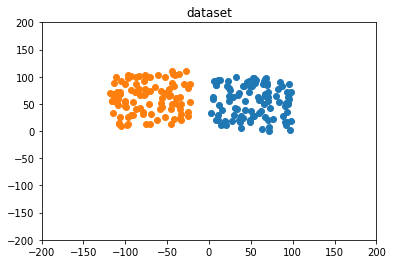

In [44]:
m.show_dataset(dataset)

### Run optimization and Parallel Nearest Neighbors

In [45]:
opt_dataset = m.optimize(dataset)

  Iterations : 1024
  Calculated : [ 0.30999834 -0.49527298  0.00458596]


### Show the first four iterations

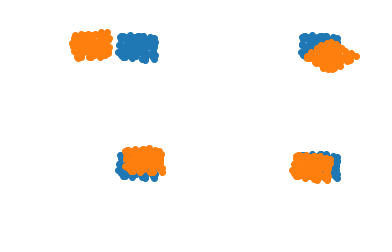

In [46]:
m.show_dataset(opt_dataset, name = "result_subplot", subplot = True)

### Show the final result

In [47]:
a, b, r = opt_dataset
dataset = (a, b)

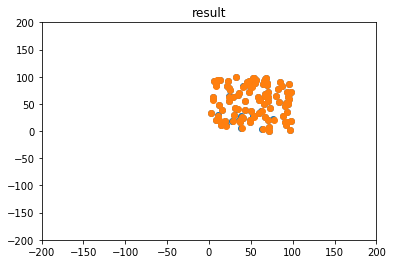

In [48]:
m.show_dataset(dataset, name = "result")